In [1]:
from lifelines import KaplanMeierFitter
import requests, random, time, re
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from dateutil import parser
from tqdm import tqdm
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns  = 200
import numpy as np

In [2]:
df = pd.read_csv("./data/b17_data/b17_data_cleaned.csv")
df['assignment_place'] = df['assignment_place'].fillna('').astype(str)
df.sample()

,serial_number,production_block,manufacturer,fate,fate_date,missions,assignment_place,assignment_date
3241,42-39985,B-17G-10-VE: 42-39958 to 42-40057,Lockheed/Vega,Lost by enemy aircraft,23 March 1944,NaN,730BS/452BG Deopham Green,3/1/44


In [3]:
fate_list =  df['fate'].dropna().unique().tolist(); fate_word_list =  ", ".join(sorted(fate_list))
print(f"\nNumber of unique fates in the dataset: ", len(fate_list))
print('\n\033[32m', fate_list, '\033[0m\n')


Number of unique fates in the dataset:  38

 ['Lost by flak/aa-fire', 'Lost by enemy aircraft', 'Failed to return', 'Salvaged', 'Lost by unknown reason', 'Returned to the USA', 'ditched', 'Destroyed on ground', 'Battle damaged', 'Crashed on take off', 'Crashlanding', 'Landing accident', 'Mid-air collision', 'RFC Albuquerque', 'Mid-air collision with e/a', 'Lost by mechanical fault', 'Lost by friendly-fire', 'Scrapped', 'Out of gas', 'Struck Off Charge', 'RFC Walnut Ridge', 'RFC Stillwater', 'RFC Altus', 'RFC Ontario', 'in Aphrodite Project', 'Written off', 'RFC Kingman', 'RFC Searcey Field', 'RFC Bush Field', 'used in KG 200', 'interned', 'Shot down by Swiss Air Force', 'caught fire in action', 'Disappeared', 'RFC La Mesa', 'Rammed by E/A', 'Accident', 'under restoration'] 



In [4]:
rfc_locations = ['RFC Albuquerque', 'RFC Kingman', 'RFC Altus', 'RFC Walnut Ridge', 'RFC Searcey Field', 'RFC Ontario', 'RFC Stillwater']
fate_replacement = {location: 'Returned to the USA' for location in rfc_locations}    # Create a dictionary where all values are 'Returned to the USA'
df['fate'] = df['fate'].replace(fate_replacement)    # Replace the values in the 'fate' column based on the dictionary

In [5]:
fate_list = ['Lost by enemy aircraft', 'Battle damaged', 'Crashlanding', 'Lost by flak/aa-fire', 'Landing accident', 'Lost by mechanical fault',
                'Failed to return', 'ditched', 'Mid-air collision', 'Salvaged', 'interned', 'Lost by unknown reason', 'Destroyed on ground',
                'Written off', 'Struck Off Charge', 'Lost by friendly-fire', 'Disappeared', 'Crashed on take off', 'Out of gas', 'Returned to the USA'] 

In [6]:
df_filtered = df[df['fate'].isin(fate_list)]

In [7]:
fate_list =  df_filtered['fate'].dropna().unique().tolist(); fate_word_list =  ", ".join(sorted(fate_list))
print(f"\nNumber of unique fates in the dataset: ", len(fate_list))
print('\n\033[32m', fate_list, '\033[0m\n')


Number of unique fates in the dataset:  20

 ['Lost by flak/aa-fire', 'Lost by enemy aircraft', 'Failed to return', 'Salvaged', 'Lost by unknown reason', 'Returned to the USA', 'ditched', 'Destroyed on ground', 'Battle damaged', 'Crashed on take off', 'Crashlanding', 'Landing accident', 'Mid-air collision', 'Lost by mechanical fault', 'Lost by friendly-fire', 'Out of gas', 'Struck Off Charge', 'Written off', 'interned', 'Disappeared'] 



In [8]:
places_list = df_filtered['assignment_place'].unique().tolist(); places_word_list =  ", ".join(sorted(places_list));  
print(f"\nNumber of unique places in the dataset: ", len(places_list))
serials_list = df_filtered['serial_number'].unique().tolist()
print(f"Number of serial numbers in the dataset: ", len(serials_list),'\n')
#print('\n\033[32m', places_word_list[:200], '\033[0m\n')


Number of unique places in the dataset:  1970
Number of serial numbers in the dataset:  6343 



In [9]:
places = ['Bassingbourn', 'Chelveston', 'Deenethorpe', 'Glatton', 'Molesworth', 'Podington', 'Polebrook', 'Rattlesden', 'Sth Plains', 'Sudbury', 'Thorpe Abbotts', 'Thurleigh', 
         "Gt Ashfield", "Earls Colne", "Debach" ] 

In [10]:
pattern = '|'.join(places)
df_filtered = df_filtered[df_filtered["assignment_place"].str.contains(pattern, na=False)]
df_filtered = df_filtered[df_filtered['fate_date'] != "None"]

In [11]:
places_list = df_filtered['assignment_place'].unique().tolist(); places_word_list =  ", ".join(sorted(places_list));  
print(f"\nNumber of unique places in the dataset: ", len(places_list))
serials_list = df_filtered['serial_number'].unique().tolist()
print(f"Number of serial numbers in the dataset: ", len(serials_list),'\n')
print(f"\nNumber of unique drugs in the dataset: ", len(places_list))
print('\n\033[32m', places_word_list, '\033[0m\n')


Number of unique places in the dataset:  867
Number of serial numbers in the dataset:  1719 


Number of unique drugs in the dataset:  867

 (PFF) 457BG Glatton, (PFF) 834BS/486BG [2S-S] Sudbury, 100BG Thorpe Abbotts, 303BG Molesworth, 305BG Chelverston, then transferred 407BS/92BG [PY-J] Podington, 305BG Chelveston, 306BG Thurleigh, 322BS/91BG [LG- ] Bassingbourn, 322BS/91BG [LG-A] Bassingbourn, 322BS/91BG [LG-B] Bassingbourn, 322BS/91BG [LG-C] Bassingbourn, 322BS/91BG [LG-D] Bassingbourn, 322BS/91BG [LG-E] Bassingbourn, 322BS/91BG [LG-L] Bassingbourn, 322BS/91BG [LG-M] Bassingbourn, 322BS/91BG [LG-O] Bassingbourn, 322BS/91BG [LG-P] Bassingbourn, 322BS/91BG [LG-Q] Bassingbourn, 322BS/91BG [LG-R] Bassingbourn, 322BS/91BG [LG-S] Bassingbourn, 322BS/91BG [LG-T] Bassingbourn, 322BS/91BG [LG-V] Bassingbourn, 322BS/91BG [LG-W] Bassingbourn, 322nd Bomb Squadron/91st Bomb Group [LG-M] at Bassingbourn, 323BS/306BG [RD-X] Thurleigh, 323BS/91BG Bassingbourn, 323BS/91BG [0R-L] Bassingbourn, 323B

In [12]:
df_filtered.sample()

,serial_number,production_block,manufacturer,fate,fate_date,missions,assignment_place,assignment_date
533,42-29700,B-17F-65-BO: 42-29632 to 42-29731,Boeing,Lost by enemy aircraft,29 July 1943,NaN,331BS/94BG [QE-O] Bassingbourn,17/4/43


In [13]:
def reformat_date(date_str):
    if pd.isna(date_str):
        return None
    try:
        dt = pd.to_datetime(date_str, format='%d %B %Y')
        return f"{dt.day}/{dt.month}/{dt.year % 100}"
    except Exception:
        return date_str  # if parsing fails, return original

# Apply to the specific column
df_filtered['fate_date'] = df_filtered['fate_date'].apply(reformat_date)

In [14]:
df_filtered.sample(5)

,serial_number,production_block,manufacturer,fate,fate_date,missions,assignment_place,assignment_date
5444,42-97483,B-17G-15-VE: 42-97436 to 42-97535,Lockheed/Vega,Lost by enemy aircraft,6/3/44,NaN,322BS/91BG [LG-L] Bassingbourn,24/2/44
6024,43-37812,B-17G-70-BO: 43-37674 to 43-37873,Boeing,Lost by flak/aa-fire,23/3/45,NaN,351BS/100BG [EP-P] Thorpe Abbotts,16/6/44
658,42-29825,B-17F-70-BO: 42-29732 to 42-29831,Boeing,Crashlanding,16/9/43,NaN,511BS/351BG [DS-Z] Polebrook,25/4/43
3051,42-31509,B-17G-20-BO: 42-31432 to 42-31631,Boeing,Battle damaged,6/8/44,44.00,508BS/351BG [YB-V] Polebrook,14/1/44
4784,42-37938,B-17G-20-DL: 42-37894 to 42-37988,Douglas,Returned to the USA,12/6/45,NaN,323BS/91BG [OR-E] Bassingbourn,30/3/44


In [15]:
import pandas as pd

def parse_dates(date_str):    
    # Function to handle multiple date formats
    if isinstance(date_str, pd.Timestamp):
        return date_str  # Skip if it's already a Timestamp
    
    try:
        # First try: expected format dd MonthName yyyy (e.g., 06 April 1944)
        parsed_date = pd.to_datetime(date_str, format='%d %B %Y', errors='raise')
        return parsed_date
    except Exception:
        try:
            # Second try: expected format dd/mm/yy (e.g., 31/01/44)
            parsed_date = pd.to_datetime(date_str, format='%d/%m/%y', errors='raise')
            
            # Adjust the year if the parsed date is in the 2000s but should be in the 1900s
            if parsed_date.year >= 2000:
                parsed_date = parsed_date.replace(year=parsed_date.year - 100)
            return parsed_date
        except Exception:
            return pd.NaT

# Apply the date parsing to both start and end dates
df_filtered['start_date'] = df_filtered['assignment_date'].apply(parse_dates)
df_filtered['end_date']   = df_filtered['fate_date'].apply(parse_dates)

# Verify the changes by checking the first few rows
df_filtered.sample(5)

,serial_number,production_block,manufacturer,fate,fate_date,missions,assignment_place,assignment_date,start_date,end_date
4984,42-39765,B-17G-1-VE: 42-39758 to 42-39857,Lockheed/Vega,Returned to the USA,24/7/45,NaN,359BS/303BG Molesworth,11/10/43,1943-10-11,1945-07-24
6813,43-38945,B-17G-100-BO: 43-38874 to 43-39073,Boeing,Returned to the USA,30/6/45,NaN,351BS/100BG [EP-F] Thorpe Abbotts,2/11/44,1944-11-02,1945-06-30
5449,42-97489,B-17G-15-VE: 42-97436 to 42-97535,Lockheed/Vega,Crashed on take off,20/5/44,NaN,326BS/92BG [JW-F] Podington,23/1/44,1944-01-23,1944-05-20
388,42-29555,B-17F-60-BO: 42-29532 to 42-29631,Boeing,Lost by enemy aircraft,28/9/43,NaN,422BS/305BG [JJ-Y/D] Chelveston,6/4/43,1943-04-06,1943-09-28
4674,42-37780,B-17G-10-DL: 42-37721 to 42-37803,Douglas,Battle damaged,16/7/44,NaN,401BG Deenethorpe,27/10/43,1943-10-27,1944-07-16


In [16]:
# Handle missing end_date by filling with a date beyond the last known end date
plot_end_date = df_filtered['end_date'].max()  # Ensure it's a datetime object
if pd.isna(plot_end_date):
    plot_end_date = df_filtered['start_date'].max() + pd.Timedelta(days=10)  # Add 10 days if all are NaN

# Replace NaT values in 'end_date' with the computed plot_end_date
df_filtered['end_date'] = df_filtered['end_date'].fillna(plot_end_date)
df_filtered.sample(5)

,serial_number,production_block,manufacturer,fate,fate_date,missions,assignment_place,assignment_date,start_date,end_date
2028,42-31984,B-17G-35-BO: 42-31932 to 42-32116,Boeing,Lost by flak/aa-fire,20/7/44,NaN,407BS/92BG [PY-U] Podington,2/3/44,1944-03-02,1944-07-20
5837,43-37531,B-17G-65-BO: 43-37509 to 43-37673,Boeing,Lost by flak/aa-fire,2/11/44,NaN,708BS/447BG Rattlesden,8/5/44,1944-05-08,1944-11-02
4155,42-31408,B-17G-15-BO: 42-31332 to 42-31431,Boeing,Lost by enemy aircraft,3/8/44,NaN,407BS/92BG [PY-Z] Podington,27/12/43,1943-12-27,1944-08-03
6274,43-38160,B-17G-80-BO: 43-38074 to 43-38273,Boeing,Returned to the USA,8/6/45,NaN,613BS/401BG [IN-A] Deenethorpe,11/8/44,1944-08-11,1945-06-08
1871,43-37795,B-17G-70-BO: 43-37674 to 43-37873,Boeing,Returned to the USA,5/7/45,NaN,709BS/447BG Rattlesden,16/6/44,1944-06-16,1945-07-05


In [17]:
# If you know the format, you can specify it here, like '%d/%m/%y'
#df_filtered['fate_date'] = pd.to_datetime(df_filtered['fate_date'], format='%d/%m/%y', errors='coerce')

# Handle missing end_date by filling with a date beyond the last known end date
plot_end_date = df_filtered['end_date'].max()                                 # Ensure it's a datetime object
if pd.isna(plot_end_date):
    plot_end_date = df_filtered['start_date'].max() + pd.Timedelta(days=10)   # Add 10 days if all are NaN
df_filtered['end_date'] = df_filtered['end_date'].fillna(plot_end_date)       # Replace NaT values in 'fate_date' with the computed plot_end_date
df_filtered = df_filtered.sort_values('start_date').reset_index(drop=True)    # Sort by 'start_date' and reset index
df_filtered.sample(5)

,serial_number,production_block,manufacturer,fate,fate_date,missions,assignment_place,assignment_date,start_date,end_date
1461,43-38480,B-17G-90-BO 43-38474 to 43-38673,Boeing,Lost by friendly-fire,30/9/44,NaN,860BS/493BG [NG-S] Debach,13/9/44,1944-09-13,1944-09-30
811,42-107010,B-17G-35-DL: 42-106984 to 42-107233,Douglas,Lost by mechanical fault,27/12/44,NaN,385BG Gt Ashfield,3/3/44,1944-03-03,1944-12-27
615,42-31277,B-17G-10-BO: 42-31232 to 42-31331,Boeing,Lost by flak/aa-fire,8/5/44,NaN,327BS/92BG [UX-P] Podington,21/1/44,1944-01-21,1944-05-08
273,42-31042,B-17G-1-BO: 42-31032 to 42-31131,Boeing,Lost by enemy aircraft,26/11/43,NaN,385BG Gt Ashfield,10/10/43,1943-10-10,1943-11-26
112,42-30146,B-17F-90-BO: 42-30132 to 42-30231,Boeing,Lost by flak/aa-fire,29/7/43,NaN,333BS/94BG [TS-A] Earls Colne,24/5/43,1943-05-24,1943-07-29


In [18]:
for idx, row in df_filtered.iterrows():
    if row['start_date'] > row['end_date']:                 # Check if the start_date is after the end_date
        df_filtered.at[idx, 'start_date'], df.at[idx,       # Swap the values of start_date and end_date
        'end_date'] = row['end_date'], row['start_date']
        print(f"Swapped dates for serial_number: {row['serial_number']}")

Swapped dates for serial_number: 42-31538
Swapped dates for serial_number: 42-38168
Swapped dates for serial_number: 41-24619
Swapped dates for serial_number: 42-31441
Swapped dates for serial_number: 43-37976
Swapped dates for serial_number: 42-39820


In [19]:
fate_list =  df_filtered['fate'].dropna().unique().tolist(); fate_word_list =  ", ".join(sorted(fate_list))
print(f"\nNumber of unique fates in the dataset: ", len(fate_list))
print('\n\033[32m', fate_list, '\033[0m\n')


Number of unique fates in the dataset:  18

 ['Lost by flak/aa-fire', 'Salvaged', 'Failed to return', 'Lost by enemy aircraft', 'Battle damaged', 'Returned to the USA', 'Lost by unknown reason', 'ditched', 'Crashlanding', 'Landing accident', 'Mid-air collision', 'Lost by mechanical fault', 'Crashed on take off', 'interned', 'Written off', 'Lost by friendly-fire', 'Out of gas', 'Destroyed on ground'] 



In [20]:
df_filtered['duration'] = (df_filtered['end_date'] - df_filtered['start_date']).dt.days

In [21]:
# List of fates that are considered as "events" (not censored)
event_fates = ['Salvaged', 'Lost by enemy aircraft', 'Landing accident', 'Lost by flak/aa-fire', 'ditched', 'Failed to return', 'Crashlanding', 
               'Mid-air collision', 'Written off', 'Battle damaged', 'Lost by friendly-fire', 'Lost by mechanical fault', 'interned', 'Destroyed on ground', 'Crashed on take off'] 

# Apply the condition to check if 'fate' is in the event_fates list
df_filtered['event'] = df_filtered['fate'].apply(lambda x: 1 if x in event_fates else 0)

In [22]:
df_filtered.tail(5)

,serial_number,production_block,manufacturer,fate,fate_date,missions,assignment_place,assignment_date,start_date,end_date,duration,event
1714,43-39072,B-17G-100-BO: 43-38874 to 43-39073,Boeing,Returned to the USA,22/5/45,NaN,748BS/457BG [S] Glatton 3/45; Returned to the ...,22/5/45,1945-05-22,1945-05-22,0,0
1715,44-83609,B-17G-90-DL: 44-83586 to 44-83685,Douglas,Returned to the USA,12/9/45,NaN,303BG Molesworth,24/5/45,1945-05-24,1945-09-12,111,0
1716,42-102614,B-17G-55-BO: 42-102544 to 42-102743,Boeing,Returned to the USA,26/6/45,119.00,551BS/385BG [HR-H] Gt Ashfield; 119m Returned ...,26/6/45,1945-06-26,1945-06-26,0,0
1717,43-39258,B-17G-105-BO: 43-39074 to 43-39273,Boeing,Returned to the USA,5/7/45,NaN,351BS/100BG [EP-M] Thorpe Abbotts 4/45; Return...,5/7/45,1945-07-05,1945-07-05,0,0
1718,43-39321,B-17G-110-BO: 43-39274 to 43-39508,Boeing,Returned to the USA,11/7/45,3.00,834BS/486BG [2S-T] Sudbury 4/45; {3m} Returned...,11/7/45,1945-07-11,1945-07-11,0,0


In [23]:
# Initialize KaplanMeierFitter
kmf = KaplanMeierFitter()
# Fit the data (duration and event columns)
kmf.fit(df_filtered['duration'], event_observed=df_filtered['event'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1719 total observations, 385 right-censored observations>

In [24]:
# Get the time where survival is 50%
median_survival_time = kmf.median_survival_time_
print(f"Median survival time: {median_survival_time}")

Median survival time: 141.0


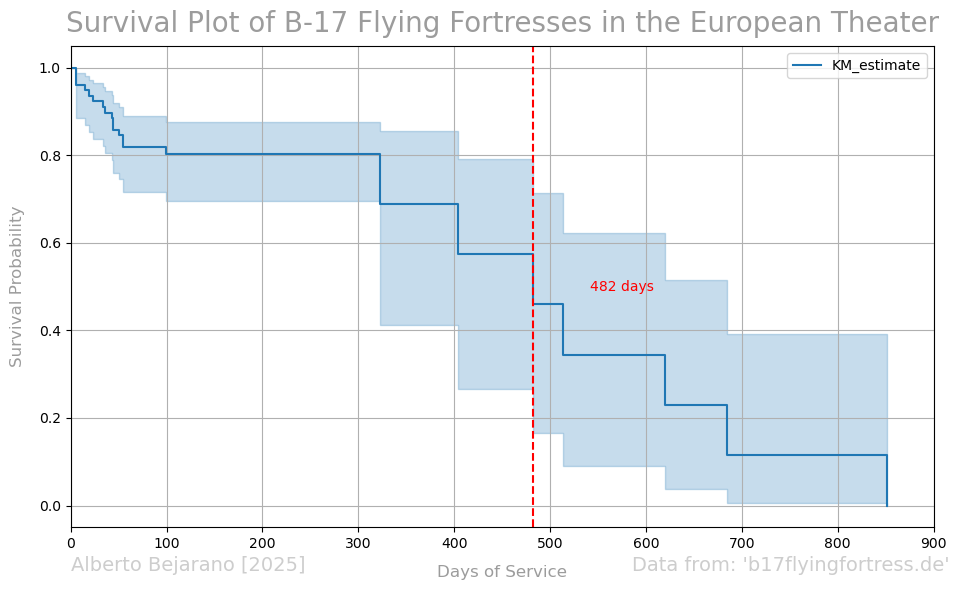

In [29]:
# Plot the survival curve
fig, ax = plt.subplots(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Survival Plot of B-17 Flying Fortresses in the European Theater', color='#9c9c9c', fontsize=20, pad=10)
plt.xlabel('Days of Service',                                                color='#9c9c9c', fontsize=12, labelpad=10)
plt.ylabel('Survival Probability',                                           color='#9c9c9c', fontsize=12, labelpad=10)

# Add vertical line at median survival
plt.axvline(median_survival_time, color='red', linestyle='--')
plt.text(median_survival_time + 60, 0.50, f'{median_survival_time:.0f} days', color='red', ha='left', va='center')

plt.xlim(0, 900)
#         .         .         .         .         .         .         .         .         .         .         .
text_kws = dict(color='#9c9c9c', ha='left', va='center', fontsize=14, alpha=0.5, transform=ax.transAxes)
plt.text(0.65, -0.08, "Data from: 'b17flyingfortress.de'",  **text_kws)
plt.text(0, -0.08,    "Alberto Bejarano [2025]",            **text_kws)
#         .         .         .         .         .         .         .         .         .         .         .
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Make sure start_date is datetime
df_filtered['start_date'] = pd.to_datetime(df_filtered['start_date'])

# Extract the year
df_filtered['start_year'] = df_filtered['start_date'].dt.year

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

Year: 1943 	Median survival time: 115.0 days 	 Number planes: 513
Year: 1944 	Median survival time: 151.0 days 	 Number planes: 1114
Year: 1945 	Median survival time: 482.0 days 	 Number planes: 82


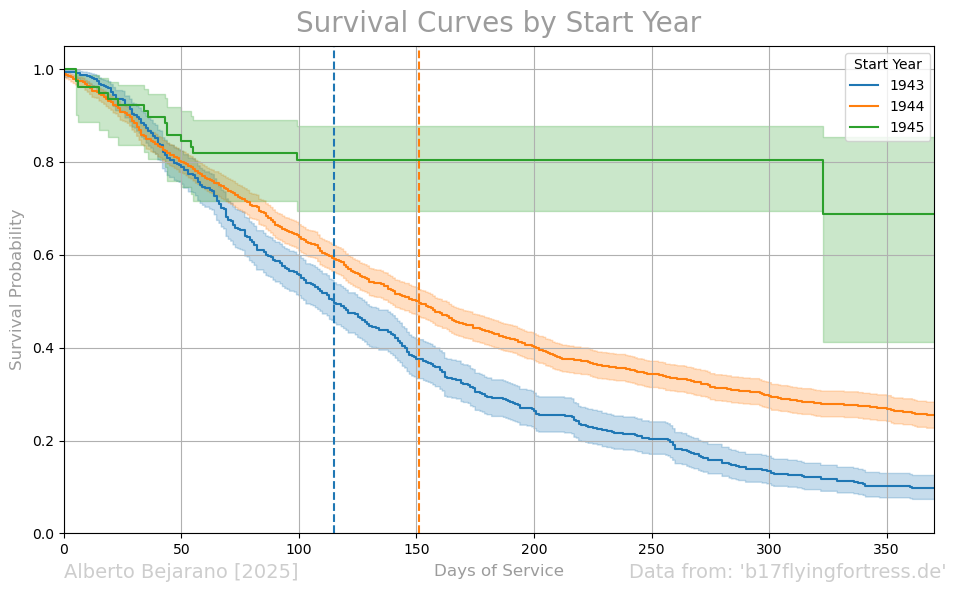

In [32]:
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Get unique years sorted
years = sorted(df_filtered['start_year'].dropna().unique())
years = [1943, 1944, 1945]
# Loop through each year and plot
for year in years:
    #print(f"Number planes {year}: {len(df_year)}")
    df_year = df_filtered[df_filtered['start_year'] == year]
    if len(df_year) < 5:  # Skip years with too few planes
        continue
    
    kmf.fit(df_year['duration'], event_observed=df_year['event'])
    kmf.plot_survival_function(ci_show=True, label=str(year))       # no confidence interval, add label
    
    median_survival_time = kmf.median_survival_time_
    print(f"Year: {year} \tMedian survival time: {median_survival_time} days \t Number planes: {len(df_year)}")
    color = ax.get_lines()[-1].get_color()
    plt.axvline(median_survival_time, color=color, linestyle='--')
    #plt.text(median_survival_time, 0.50, f'{median_survival_time:.0f} days', color=color, ha='left', va='center')

# Decorations
plt.title('Survival Curves by Start Year', color='#9c9c9c', fontsize=20, pad=10)
plt.xlabel('Days of Service',              color='#9c9c9c', fontsize=12, labelpad=5)
plt.ylabel('Survival Probability',         color='#9c9c9c', fontsize=12, labelpad=5)
plt.xlim(0, 370)  # limit x-axis to 300 days
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(title='Start Year', bbox_to_anchor=(0.89, 1), loc='upper left')  # move legend outside
#         .         .         .         .         .         .         .         .         .         .         .
text_kws = dict(color='#9c9c9c', ha='left', va='center', fontsize=14, alpha=0.5, transform=ax.transAxes)
plt.text(0.65, -0.08, "Data from: 'b17flyingfortress.de'",  **text_kws)
plt.text(0, -0.08,    "Alberto Bejarano [2025]",            **text_kws)
#         .         .         .         .         .         .         .         .         .         .         .
plt.tight_layout()
plt.show()